In [1]:
# Загрузка библиотек
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
from tqdm.auto import tqdm

plt.style.use('ggplot')
from scipy.stats import norm
import scipy
import scipy.sparse
import seaborn as sns

import scipy.stats as stats
from scipy.stats import chi2_contingency

# Вариант2 A/B тесты

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Презентация на основе данных доступна здесь: New payment method (лежит в этой же папке) 


## Загрузка данных, объединение таблиц

In [3]:
# строка для считывания файлов с яндекс диска
url = 'https://getfile.dokpub.com/yandex/get/'

In [4]:
# groups = pd.read_csv(url +'https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep = ';')

groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-davydov/Проект_2_groups.csv', sep = ';')

In [5]:
# проверяем правильно ли загрузилось, А – контроль, B – целевая группа
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
# смотрим размер датасета
groups.shape

(74484, 2)

In [7]:
# Немного EDA
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [8]:
#added_users = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' Ссылка больше не работает - превышен лимит скачиваний
#added_users_df = pd.read_csv(url + added_users)

In [9]:
added_users_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ar-davydov/Проект_2_group_add.csv')


In [10]:
# проверяем правильно ли загрузилось
added_users_df.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
# смотрим размер датасета
added_users_df.shape

(92, 2)

In [12]:
# Немного EDA
added_users_df.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [13]:
active_studs = pd.read_csv(url + 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')

In [14]:
# проверяем правильно ли загрузилось
# смотрим размер датасета
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [15]:
checks = pd.read_csv(url + 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep =';')

In [16]:
# проверяем правильно ли загрузилось
# смотрим размер датасета
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


## Объединение таблиц, файлов 

In [17]:
# объединение таблиц, добавление строк к основному датафрейму из файла присланного позже
df = pd.concat([groups, added_users_df], ignore_index=True)

In [18]:
# смотрим размер датасета
df.shape

(74576, 2)

In [19]:
74576- 92 # проверка

74484

In [20]:
# объединение таблиц и EDA, датасет с только оплатившими студентами
only_payd_students = df.merge(checks, left_on='id', right_on='student_id')

In [21]:
# 541 оплативший
only_payd_students.shape[0]

541

In [22]:
# Посчитаем число оплативших и средний чек в контрольной и тестовой группах
only_payd_students.groupby('grp').agg({'rev':['mean', 'count']}).reset_index()

grp          rev      
              mean count
0   A   860.710280   107
1   B  1108.824893   434

In [23]:
# сделаем полный датасет с информацией об оплате, группе, активности во время эксперимента
full_df = df.merge(checks, left_on='id', right_on='student_id', how = 'outer').merge(active_studs, left_on='id', right_on='student_id', how = 'outer')

In [24]:
full_df

,id,grp,student_id_x,rev,student_id_y
0,1489,B,NaN,NaN,NaN
1,1627,A,1627.0,990.0,1627.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,NaN
74572,201032527,B,NaN,NaN,NaN
74573,201067612,B,NaN,NaN,NaN
74574,201067653,B,NaN,NaN,NaN


In [25]:
# Посмотрим еще раз количество оплативших и активных (и проверим себя)
full_df.student_id_x.count(), full_df.student_id_y.count() 

(541, 8341)

# EDA - разведывательный анализ

In [26]:
# Создадим таблицу с метриками и для дальнейшего расчета метрик
tab = full_df.query('student_id_y > 0') \
            .groupby('grp') \
            .agg({'rev':['sum', 'mean', 'median', 'count'], 'student_id_y' : 'count' }) \
            .rename(columns = {'sum' : 'сумма_дохода', 'mean' : 'ср_арфм_доход_с_акт_юзера',\
                                'median': 'медиана_ср_дода_с_акт_юзера', 'count': 'число_оплативших_акт_юзеров/число_акт_юзеров'}) \
            .reset_index()
tab

grp          rev                                                        \
      сумма_дохода ср_арфм_доход_с_акт_юзера медиана_ср_дода_с_акт_юзера   
0   A   72820.0000                933.589744                       585.0   
1   B  394974.0035               1257.878992                      1140.0   

                                                \
  число_оплативших_акт_юзеров/число_акт_юзеров   
0                                           78   
1                                          314   

                                  student_id_y  
  число_оплативших_акт_юзеров/число_акт_юзеров  
0                                         1538  
1                                         6803

In [27]:
# число активных (проверяю, что правильно отфильтровал)
full_df.query('student_id_y > 0').shape[0]

8341

In [28]:
# убеждаюсь, что в расчетах будут нужные значения
tab['student_id_y']['число_оплативших_акт_юзеров/число_акт_юзеров'] 

0    1538
1    6803
Name: число_оплативших_акт_юзеров/число_акт_юзеров, dtype: int64

In [29]:
# убеждаюсь, что в расчетах будут нужные значения
tab['rev']['число_оплативших_акт_юзеров/число_акт_юзеров'] 

0     78
1    314
Name: число_оплативших_акт_юзеров/число_акт_юзеров, dtype: int64

In [30]:
# процент оплативших среди активных (пользователей, которые зашли на платформу в дни проведения эксперимента)
tab['rev']['число_оплативших_акт_юзеров/число_акт_юзеров']  / tab['student_id_y']['число_оплативших_акт_юзеров/число_акт_юзеров'] * 100

0    5.071521
1    4.615611
Name: число_оплативших_акт_юзеров/число_акт_юзеров, dtype: float64

In [31]:
# ради интереса - средний чек на активного пользователя (не обязательно оплатившего)
tab['rev']['сумма_дохода']  / tab['student_id_y']['число_оплативших_акт_юзеров/число_акт_юзеров'] 

0    47.347204
1    58.058798
dtype: float64

A - контрольная группа
B - тестовая группа

Ознакомиться с новой механикой оплаты услуг на сайте могли только те пользователи, которые были активны во время проведения эксперимента, т.е. заходили на сайт - поэтому для анализа представляет интерес только их поведение.

Мы видим, что средний чек выше среди тестовой группы (1257 у.е. против 933 у.е. в контрольной), но конверсия выше среди контрольной группы (5,07% против 4,62% в тестовой)

Что можно еще сделать? Посмотреть на распределение платежей. Сравнить активных и неактивных пользователей


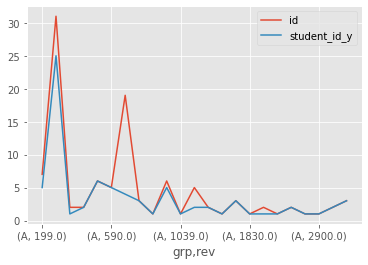

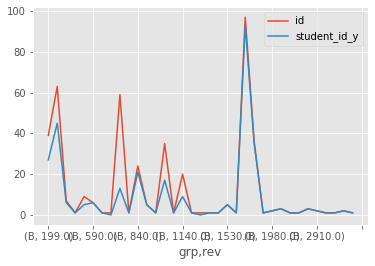

In [32]:
# full_df.groupby(['grp', 'rev']).count() - здесь не очень наглядная табличка с частотой оплат по определенным суммам
# Для наглядности набросал эскизы графиков, по ним видно, что в группе А более популярны малые чеки, в группе B  - средние и большие

# Группа А
full_df.groupby(['grp', 'rev']).agg({'id':'count' , 'student_id_y' : 'count'}).query('grp == "A"').plot()

# Группа В
full_df.groupby(['grp', 'rev']).agg({'id':'count', 'student_id_y' : 'count'}).query('grp == "B"').plot()
# id - все пользователи, student_id_y - только активные пользователи

# T-test или тест Манна-Уитни

In [34]:
# Посмотрим распределение зависимой переменной, в идеале нужно нормальное
# Выполняем тест Шапиро-Уилка
stat, p = stats.shapiro(full_df.query('student_id_y > 0  and rev > 0').rev)

# Выводим результаты
print('Статистика теста:', stat)
print('p-значение:', p)
if p > 0.05: # Чтобы меньше думать потом
    print('Распределение является нормальным')
else:
    print('Распределение не является нормальным')

Статистика теста: 0.8714179396629333
p-значение: 1.6449447664488742e-17
Распределение не является нормальным


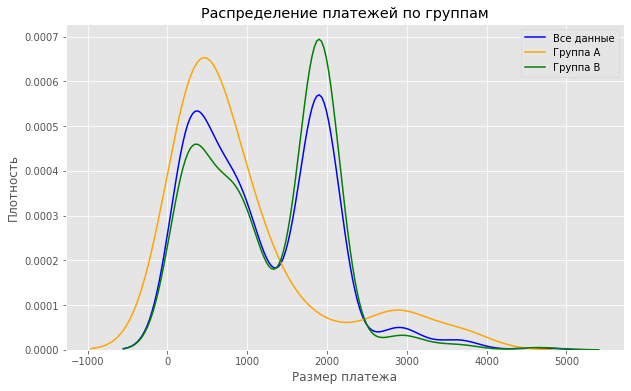

In [35]:
%matplotlib inline
plt.figure(figsize=(10, 6)) # сделаем график побольше
# По графику тоже видно отсутствие нормальности распределения
sns.kdeplot(full_df.query('student_id_y > 0 and rev > 0').rev, color='blue', label='Все данные') # все данные
sns.kdeplot(full_df.query('student_id_y > 0 and rev > 0 and grp == "A"').rev, color='orange', label='Группа А') # группа А
sns.kdeplot(full_df.query('student_id_y > 0 and rev > 0 and grp == "B"').rev, color='green', label='Группа B') # группа В
plt.title('Распределение платежей по группам')
plt.xlabel('Размер платежа')
plt.ylabel('Плотность')
plt.legend()

# Отображаем график
plt.show()



# Т-тест нельзя делать

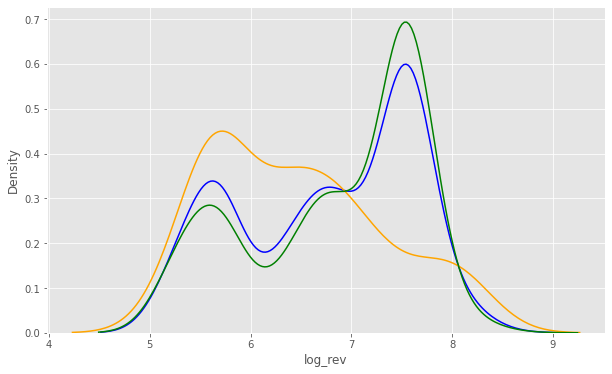

In [36]:
%matplotlib inline
plt.figure(figsize=(10, 6))
# Попытаемся нормализовать с помощью логарифмирования 
full_df['log_rev'] = np.log(full_df.query('student_id_y > 0  and rev > 0').rev)

sns.kdeplot(full_df.query('student_id_y > 0 and rev > 0').log_rev, color='blue', label='Все данные') 
sns.kdeplot(full_df.query('student_id_y > 0 and rev > 0 and grp == "A"').log_rev, color='orange', label='Группа А')
sns.kdeplot(full_df.query('student_id_y > 0 and rev > 0 and grp == "B"').log_rev, color='green', label='Группа B')

# не помогло - распределение ненормальное, для точности повторим тест Шапиро-Уилка

In [37]:
# Повторяем тест Шапиро-Уилка на логарифмированной переменной
stat, p = stats.shapiro(full_df.query('student_id_y > 0  and rev > 0').log_rev)

# Выводим результаты
print('Статистика теста:', stat)
print('p-значение:', p)
if p > 0.05:
    print('Распределение является нормальным')
else:
    print('Распределение не является нормальным')


Статистика теста: 0.8821048736572266
p-значение: 9.399240727294743e-17
Распределение не является нормальным


In [38]:
# Но все равно сделаем т-тест, из интереса
# для т-теста надо избавиться от NULL
full_df['rev_zero'] = full_df['rev'].fillna(0)

In [42]:
# Заодно посмотрим средние тогда
full_df.query('student_id_y > 0') \
            .groupby('grp') \
            .agg({'rev_zero':['sum', 'mean', 'median']}) \
            .rename(columns = {'sum' : 'сумма_дохода', 'mean' : 'ср_арфм_доход',\
                                'median': 'медиана_ср_дода'}) \
            .reset_index()

# медианы одинаковые

grp     rev_zero                              
      сумма_дохода ср_арфм_доход медиана_ср_дода
0   A   72820.0000     47.347204             0.0
1   B  394974.0035     58.058798             0.0

In [44]:
# Т-тест с 0 вместо nan
# Выполняем t-тест
t_stat, p_value = stats.ttest_ind(full_df.query('student_id_y > 0 and grp == "B"').rev_zero, full_df.query('student_id_y > 0 and grp == "A"').rev_zero)
                                  
# Выводим результаты
print("t-статистика:", t_stat)
print("p-значение:", p_value)

t-статистика: 1.2253411073793445
p-значение: 0.22048133326988378


In [45]:
# Т-тест без 0, по только оплатившим пользователям и бывшим активными во время эксперимента 
# Выполняем t-тест
t_stat, p_value = stats.ttest_ind(full_df.query('student_id_y > 0 and grp == "B" and rev > 0').rev, full_df.query('student_id_y > 0 and grp == "A" and rev > 0').rev)
                                  
# Выводим результаты
print("t-статистика:", t_stat)
print("p-значение:", p_value)

# Есть статистически значимые различия

t-статистика: 3.1337795050930985
p-значение: 0.0018562025265765867


In [48]:
# Делаем тест Манна-Уитни

stat, p = mannwhitneyu(full_df.query('student_id_y > 0 and grp == "A" and rev > 0').rev, full_df.query('student_id_y > 0 and grp == "B" and rev > 0').rev)

# Выводим результаты
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Нет статистически значимых различий')
else:
    print('Есть статистически значимые различия')

stat=9001.000, p=0.000
Есть статистически значимые различия


Новая механика оплаты никак не может повлиять на конверсию из пользователя в активного пользователя (пользователя, который заходил на сайт во время эксперимента), но мне просто интересно посчитать эту метрику

In [51]:
full_df.head(2) # для наглядности
# student_id_x - оплатившие студенты
# student_id_y - активные во время эксперимента
# id - все доступные для анализа пользователи

,id,grp,student_id_x,rev,student_id_y,log_rev,rev_zero
0,1489,B,NaN,NaN,NaN,NaN,0.0
1,1627,A,1627.0,990.0,1627.0,6.897705,990.0


In [52]:
cr = full_df.groupby('grp').agg({'student_id_y' : 'count', 'id' : 'count'}).reset_index()
cr

,grp,student_id_y,id
0,A,1538,14693
1,B,6803,59883


In [53]:
# конверсия из пользователя в активного пользователя (пользователя, который заходил на сайт во время эксперимента)
cr.student_id_y /cr.id *100

0    10.467570
1    11.360486
dtype: float64

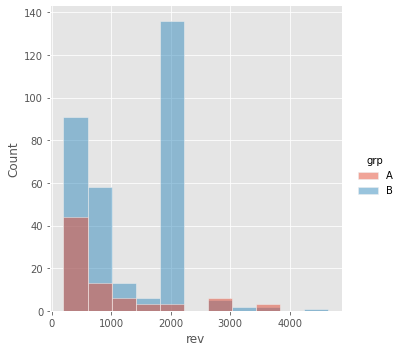

In [54]:
# Оплаты по 2 группам
sns.displot(full_df.query('rev > 0 and student_id_y > 0'), x="rev", hue="grp")

In [49]:
# Дополнительно создадим функцию бутстрапа для сравнения средних

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

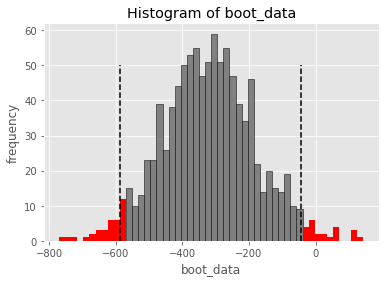

In [50]:
# прмиеним к нашим данным функцию бутстрапа для сравнения средних
booted_data = get_bootstrap(full_df.query('student_id_y > 0 and grp == "A" and rev > 0').rev, full_df.query('student_id_y > 0 and grp == "B" and rev > 0').rev) # в результате хранится разница двух распределений, ДИ и pvalue

In [57]:
booted_data["p_value"] # показывает статистически значимую разницу (на уровне p<0.05)

0.0242711053147806

In [58]:
booted_data["quants"] # ДИ
# не пересекают 0  - различия есть

,0
0.025,-595.578542
0.975,-45.262509


In [51]:
# Дополнительно создадим функцию бутстрапа для сравнения медиан

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

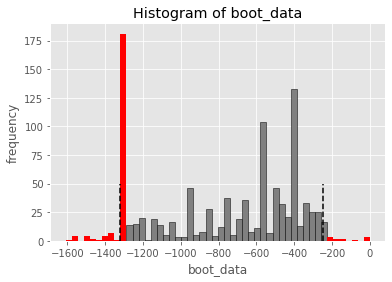

In [52]:
booted_data = get_bootstrap(full_df.query('student_id_y > 0 and grp == "A" and rev > 0').rev, full_df.query('student_id_y > 0 and grp == "B" and rev > 0').rev) # в результате хранится разница двух распределений, ДИ и pvalue

In [53]:
booted_data["p_value"] # показывает статистически значимую разницу (на уровне p<0.05)

0.04332158317675434

In [54]:
booted_data["quants"] # ДИ
# не пересекают 0  - различия есть


,0
0.025,-1320.0
0.975,-250.0


In [55]:
# создаю таблицу сопряженности 
payd_users = tab['rev']['число_оплативших_акт_юзеров/число_акт_юзеров'] 
active_users = tab['student_id_y']['число_оплативших_акт_юзеров/число_акт_юзеров'] 
observed = pd.DataFrame()
observed['payd_users'] = tab['rev']['число_оплативших_акт_юзеров/число_акт_юзеров'] 
observed['active_users'] = tab['student_id_y']['число_оплативших_акт_юзеров/число_акт_юзеров'] 
observed

,payd_users,active_users
0,78,1538
1,314,6803


In [56]:
# Проводим хи-квадрат тест
chi2, p_value, dof, expected = chi2_contingency(observed)

# Выводим результаты
print("chi2: ", chi2)
print("p-value: ", p_value)
print("degrees of freedom: ", dof)
print("expected frequencies: ", expected)

if p_value > 0.05:
    print('Статистически значимых различий не обнаружено')
if p_value < 0.05:
    print('Есть статистически значимые различия')

# Различия незначимы, даже без всяких поправок

chi2:  0.43612258061018483
p-value:  0.5089998823014525
degrees of freedom:  1
expected frequencies:  [[  72.53773045 1543.46226955]
 [ 319.46226955 6797.53773045]]
Статистически значимых различий не обнаружено


# Выводы:

1) Эксперимент показал неоднозначные результаты: не привел к увеличению конверсии (CR), но увеличил средний доход с платящего пользователя (ARPPU)

2) Новая механика оплаты генерирует больше средних чеков, меньше - маленьких, по сравнению с контрольной группой. Средний чек в группе А - 1257 у.е., в группе В - 933 у.е.

3) Необходимо рассчитать юнит-экономику и после этого принять решение о переходе на новую систему оплаты
